In [1]:
!pip install inference supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.1/190.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 12.0 MB/s et

In [14]:
import supervision as sv
from inference import get_model
from inference.core.utils.image_utils import load_image_bgr
import cv2
from collections import Counter
import numpy as np

In [15]:
# Load image
try:
    image = load_image_bgr("https://t4.ftcdn.net/jpg/03/71/04/05/360_F_371040590_tBKGwImtbbFJhMvPjiIvErtZJIODHhs0.jpg")
    if image is None:
        raise ValueError("Failed to load image from URL")
except Exception as e:
    print(f"Error loading image: {e}")
    exit(1)

In [16]:
# Load YOLOv8 large model
model = get_model(model_id="yolov8l-640")

In [17]:
# Multi-scale inference to detect vehicles of varying sizes
detections_list = []
scales = [1.0, 0.75, 0.5]
for scale in scales:
    # Resize image
    scaled_image = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
    try:
        results = model.infer(scaled_image, confidence=0.2)[0]
        scaled_detections = sv.Detections.from_inference(results)


        if len(scaled_detections.xyxy) > 0:
            scaled_detections.xyxy = scaled_detections.xyxy / scale
            detections_list.append(scaled_detections)
    except Exception as e:
        print(f"Error during inference at scale {scale}: {e}")
        continue

In [18]:
# Combine detections from all scales
if detections_list:
    detections = sv.Detections.merge(detections_list)
else:
    print("No detections from any scale")
    detections = sv.Detections(xyxy=np.array([]), confidence=np.array([]), class_id=np.array([]))

# Apply suppression
detections = detections.with_nms(threshold=0.6)


In [19]:
# Define expanded vehicle class mappings (COCO dataset)
vehicle_classes = {
    1: 'bicycle',
    2: 'car',
    3: 'motorcycle',
    5: 'bus',
    7: 'truck',
}

In [38]:
# Filter out non-vehicle detections and very small boxes
min_box_area = 10
filtered_indices = []
for i, (xyxy, cls_id, conf) in enumerate(zip(detections.xyxy, detections.class_id, detections.confidence)):
    if cls_id in vehicle_classes and conf >= 0.2:
        x1, y1, x2, y2 = xyxy
        area = (x2 - x1) * (y2 - y1)
        if area >= min_box_area:
            filtered_indices.append(i)

In [39]:
# Apply filtering for detections
if filtered_indices:
    detections = sv.Detections(
        xyxy=detections.xyxy[filtered_indices],
        confidence=detections.confidence[filtered_indices],
        class_id=detections.class_id[filtered_indices],
        tracker_id=None if detections.tracker_id is None else detections.tracker_id[filtered_indices],
        data={k: v[filtered_indices] for k, v in detections.data.items()} if detections.data else None
    )
else:
    print("No vehicle detections after filtering")
    detections = sv.Detections(xyxy=np.array([]), confidence=np.array([]), class_id=np.array([]))


In [40]:
# Count vehicles by type
vehicle_counts = Counter()
for cls_id in detections.class_id:
    vehicle_counts[vehicle_classes[cls_id]] += 1

In [41]:
# Define color mapping for each vehicle type (BGR[blue green red] format)
color_map = {
    'bicycle': (255, 0, 255),
    'car': (0, 255, 0),
    'motorcycle': (255, 0, 0),
    'bus': (0, 0, 255),
    'truck': (0, 255, 255),
}

In [42]:
# Annotate image with bounding boxes and custom colors
annotated_image = image.copy()
labels = [f"{vehicle_classes[cls_id]} {conf:.2f}" for cls_id, conf in zip(detections.class_id, detections.confidence)]
colors = [color_map[vehicle_classes[cls_id]] for cls_id in detections.class_id]

In [43]:
# Custom annotation
for box, label, color in zip(detections.xyxy, labels, colors):
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 2)
    cv2.putText(
        annotated_image,
        label,
        (x1, y1 - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        color,
        2,
        cv2.LINE_AA
    )

In [44]:
# Adding summary text with semi-transparent background
summary_text = f"Vehicle Counts: {dict(vehicle_counts)}"
font_scale = 0.8
text_size, _ = cv2.getTextSize(summary_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)
text_w, text_h = text_size

array([[[ 52,  45,  36],
        [ 59,  52,  43],
        [ 60,  53,  44],
        ...,
        [ 47,  53,  48],
        [ 46,  52,  47],
        [ 43,  49,  44]],

       [[ 51,  44,  35],
        [ 56,  49,  40],
        [ 56,  49,  40],
        ...,
        [ 42,  48,  43],
        [ 43,  49,  44],
        [ 45,  51,  46]],

       [[ 52,  45,  36],
        [ 57,  50,  41],
        [ 55,  48,  39],
        ...,
        [ 46,  52,  47],
        [ 46,  52,  47],
        [ 43,  49,  44]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [ 28,  29,  27],
        ...,
        [ 68,  66,  66],
        [ 63,  63,  63],
        [ 66,  66,  66]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [ 90,  88,  88],
        [ 67,  67,  67],
        [ 63,  63,  63]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [119, 117, 117],
        [ 76,  76,  76],
        [ 63,  63,  63]]], dtype=uint8)
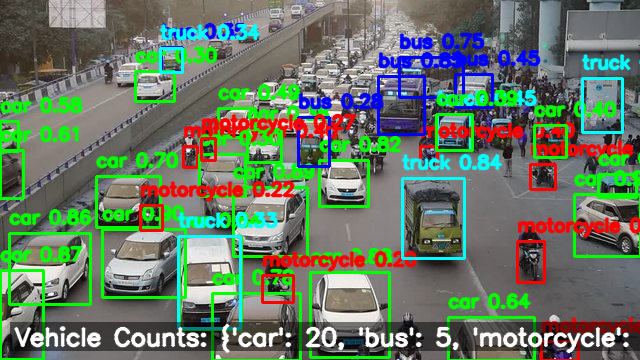

In [45]:
# Adding semi-transparent background for text
overlay = annotated_image.copy()
cv2.rectangle(
    overlay,
    (10, annotated_image.shape[0] - text_h - 20),
    (10 + text_w + 10, annotated_image.shape[0] - 10),
    (0, 0, 0, 180),
    -1
)
alpha = 0.5
cv2.addWeighted(overlay, alpha, annotated_image, 1 - alpha, 0, annotated_image)

# Adding summary text
cv2.putText(
    img=annotated_image,
    text=summary_text,
    org=(15, annotated_image.shape[0] - 15),
    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    fontScale=font_scale,
    color=(255, 255, 255),
    thickness=2,
    lineType=cv2.LINE_AA
)

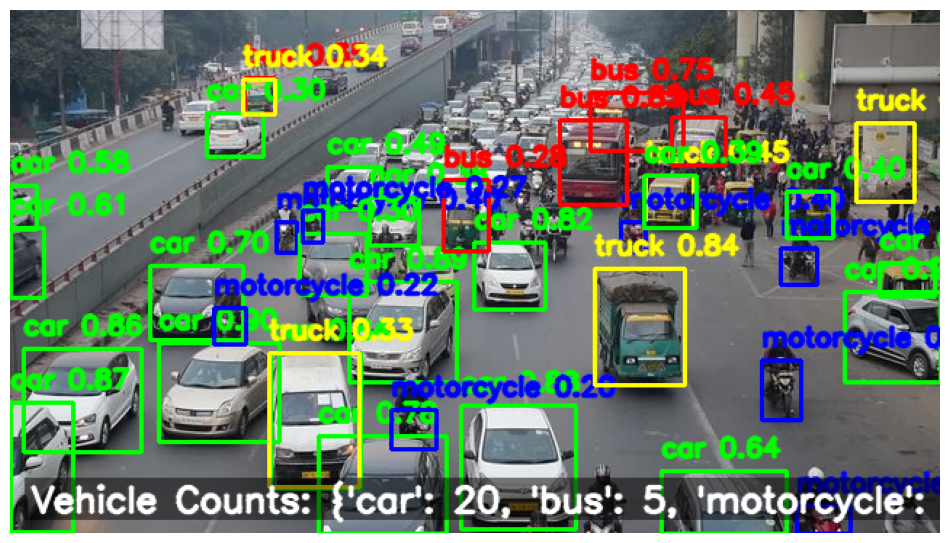

Annotated image saved as 'annotated_vehicles_fullscan.jpg'
Detected vehicles: {'car': 20, 'bus': 5, 'motorcycle': 8, 'truck': 5}


In [46]:
# Save and display the annotated image
try:
    cv2.imwrite("annotated_vehicles_fullscan.jpg", annotated_image)
    sv.plot_image(annotated_image)
    print(f"Annotated image saved as 'annotated_vehicles_fullscan.jpg'")
    print(f"Detected vehicles: {dict(vehicle_counts)}")
except Exception as e:
    print(f"Error saving or displaying image: {e}")